# Neural networks with PyTorch

Next I'll show you how to build a neural network with PyTorch.

In [2]:
# Import things like usual

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

우선, 데이터가 필요하다. 해당 데이터는 `torchvision` 패키지를 통해 제공된다. 아래 코드를 통해서 MNIST 데이터를 다운로드 받을 것이고, 학습 데이터와 테스트 데이터를 만들어 줄 것이다. 여기 나와있는 세부 내용은 나중에 다룰 예정임으로 신경쓰지 않아도 된다.

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

학습된 데이터는 `trainloader`안에 저장이 되고, `iter(trainloader)`를 사용한 순환자를 생성하였다. 보통 학습시에 loop를 사용하지만, 여기서는 첫번째 batch의 데이터만 뽑아 데이터를 확인하고자 한다. 아래를 보면 `images`는 크기가 (64, 1, 28, 28)인 tensor로 되어 있는 것을 확인할 수 있다. 그래서, 매 batch 때마다 64개의 이미지와 1개의 색깔 채널, 그리고 28x28 크기의 이미지로 되어 있는 것을 볼 수 있다.

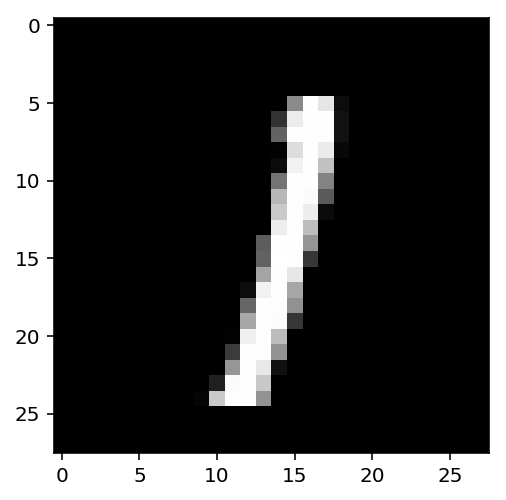

In [6]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image.

<img src="assets/mlp_mnist.png" width="600" />

To build a neural network with PyTorch, you use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. You define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a `forward` method that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), you'd do `F.relu(x)`. Below are a few different commonly used activation functions.

<img src="assets/activation.png" width="700" />

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

이제 Pytorch를 사용해서 MNIST 이미지들을 분류할 수 있는 간단한 구조의 feedforward 신경망을 만들고자 한다. 다시 말해, 신경망이 입력으로 숫자 이미지를 받고, 이미지 상의 숫자를 예측하는 것이다.

<img src="assets/mlp_mnist.png" width="600" />

Pytorch를 사용해서 신경망을 만들기 위해, 여기서는 `torch.nn` 모듈을 사용했다. 신경망 자체는 `torch.nn.Module`라는 모듈을 상속받는 클래스로 되어 있다. 748개의 입력을 받고, 128개의 노드로 구성되어 있는 fully connected layer를 생성하는데 `nn.Linear(784, 128)`라고 정의하는 것처럼, 계층을 각각 정의할 수 있다.

해당 class는 신경망을 통과하는 forward pass를 구현한 `forward`란 method가 포함되어야 한다. 이 함수안에다, 앞에서 사전에 정의한 각 계층을 통과시킬 입력 tensor `x`를 인자로 넣을 것이다. `torch.nn` 모듈은 `torch.nn.functional`안에 정의되어 있는 ReLU와 기능적으로 동일하게 동작하는 것도 가지고 있다. 해당 모듈은 일반적으로 `F`라는 이름으로 가져온다. (단지 tensor로만 되어 있는) 몇몇 계층에서 ReLU 활성 함수를 사용하기 위해서는, `F.relu(x)`를 수행하면 된다. 아래의 그림들은 흔하게 사용되는 활성함수들을 보여주고 있다.

<img src="assets/activation.png" width="700px" />

이번 신경망 설계시 3개의 Fully connected layer를 가지고 만든 후에 클래스를 예측하기 위한 softmax 출력을 활용할 것이다. softmax 함수는 보통 입력을 0과 1사이 값으로 압축시켜주는 sigmoid 함수와 비슷하지만, softmax는 적절한 확률분포를 띄는 것처럼 모든 함이 1이되는 값들로 정규화시켜주는 역할을 한다.

In [7]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    # x : tensor
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

weights나 자동적으로 초기화되는 값들도 있지만, 초기화시 어떻게 할 것인지 조정하는 것도 가능하다. weights와 biases들은 생성시 계층에 붙어있는 tensor 형태로 되어 있는데, `model.fc1.weight` 같은 값들을 통해서 해당 값을 얻어낼 수 있다.

In [9]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0044,  0.0329, -0.0165,  ...,  0.0090,  0.0219, -0.0300],
        [ 0.0119, -0.0032,  0.0043,  ..., -0.0159,  0.0048, -0.0062],
        [ 0.0230, -0.0248,  0.0237,  ..., -0.0251, -0.0097,  0.0105],
        ...,
        [ 0.0096, -0.0036, -0.0065,  ..., -0.0172, -0.0092,  0.0201],
        [ 0.0118,  0.0018,  0.0349,  ..., -0.0137,  0.0181,  0.0182],
        [ 0.0150,  0.0137,  0.0332,  ...,  0.0180,  0.0281,  0.0278]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0071, -0.0075,  0.0123,  0.0243, -0.0114, -0.0293, -0.0088, -0.0173,
        -0.0018,  0.0277, -0.0035, -0.0215,  0.0184, -0.0033, -0.0120, -0.0327,
        -0.0151,  0.0041, -0.0042, -0.0095,  0.0254,  0.0028,  0.0033, -0.0090,
        -0.0094,  0.0110,  0.0012,  0.0300,  0.0159,  0.0049,  0.0112, -0.0062,
         0.0253, -0.0223,  0.0193, -0.0000, -0.0335, -0.0172,  0.0158, -0.0244,
        -0.0147,  0.0198, -0.0020,  0.0126,  0.0022, -0.0298,  0.0259,  0.0300,
        -0.0317

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

초기화를 조정하기 위해서 각각의 tensor들을 적절하게 수정해야 한다. 사실 이 값들은 autograd Variable이라는 것으로, 앞의 tensor들을 `model.fc1.weight.data`라는 것으로 바꿔줄 필요가 있다. tensor가 생겼을 때, (bias로) 0이나 랜덤한 값들로 채워넣을 수 있다.

In [10]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [11]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-0.0084,  0.0013,  0.0015,  ..., -0.0013,  0.0090,  0.0003],
        [-0.0007, -0.0053, -0.0142,  ...,  0.0021, -0.0112, -0.0030],
        [ 0.0065, -0.0074,  0.0105,  ...,  0.0115, -0.0199, -0.0108],
        ...,
        [-0.0065,  0.0206,  0.0092,  ..., -0.0149,  0.0114,  0.0194],
        [ 0.0018,  0.0151, -0.0089,  ...,  0.0013, -0.0056,  0.0070],
        [-0.0021, -0.0190,  0.0065,  ..., -0.0124, -0.0017, -0.0122]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image. This is called the forward pass. We're going to convert the image data into a tensor, then pass it through the operations defined by the network architecture.

신경망이 생성되고 난 후에, 이미지를 통과시켰을때 어떻게 동작하는지 확인해보자. 이 과정을 forward pass라고 부르는데, 여기서 이미지 데이터를 tensor로 전환하고, 이 값들을 신경망 구조에 정의된 기능에 넣어보는 것을 수행할 것이다.

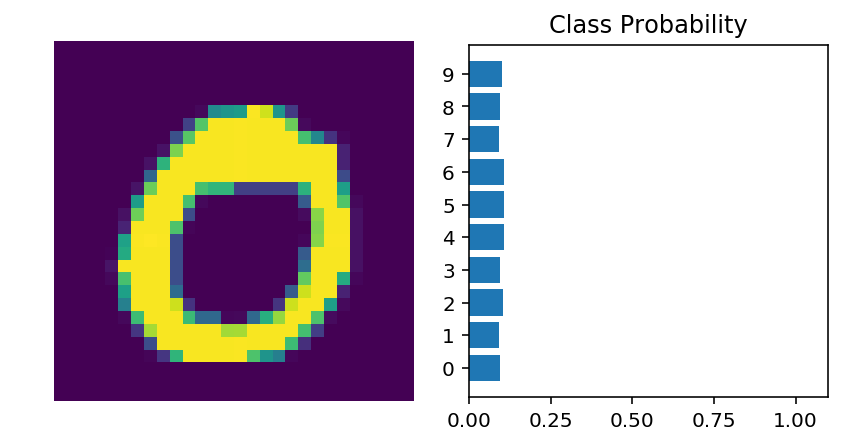

In [12]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

위에서 보는 것처럼, 지금 만들어진 신경망은 어떤 숫자가 나오는지에 대한 개념이 없다. 이건 우리가 학습시키지 않았고, 모든 weight들이 랜덤하게 설정되어 있기 때문이다.

PyTorch는 `nn.Sequential`([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential))과 같이 tensor가 연속적으로 기능을 거쳐가면서 동작하는 신경망을 쉽게 만들수 있는 방법을 제공한다. 위의 신경망과 동일한 신경망을 만들고 싶으면,

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


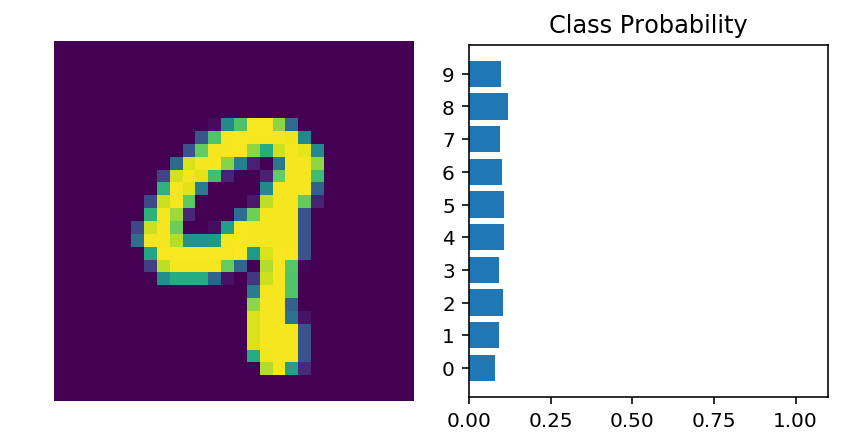

In [13]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

You can also pass in an `OrderedDict` to name the individual layers and operations. Note that a dictionary keys must be unique, so _each operation must have a different name_.

아니면 `OrderedDict`를 사용해서 각 계층과 기능에 대해서 정의하게 할 수도 있다. 유념해야 할 것은 dictionary key는 유일해야 하기 때문에, 각각의 계층은 서로 다른 이름을 가져야 한다는 것이다.

In [14]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

Now it's your turn to build a simple network, use any method I've covered so far. In the next notebook, you'll learn how to train a network so it can make good predictions.

>**Exercise:** Build a network to classify the MNIST images with _three_ hidden layers. Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. Each hidden layer should have a ReLU activation function, and use softmax on the output layer. 

이제 직접 신경망을 만들어 볼 차례인데, 위에서 다룬 방법을 사용해봐라. 다음 notebook에서 신경망을 학습시키는 방법에 대해서 다룰 것이고, 이를 통해 예측을 잘하게 될 것이다.

>**Exercise:** 3개의 hidden layer로 구성된, MNIST 이미지를 구별하는 신경망을 만들어봐라. 첫번째 hidden layer는 400개의 node를 가지고 두번째 layer는 200개, 세번째 layer는 100개를 가지게 하라. 각 hidden layer는 ReLU 활성함수를 가져야 하고, 마지막 출력 layer로는 softmax를 사용하라.

myNetwork(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)


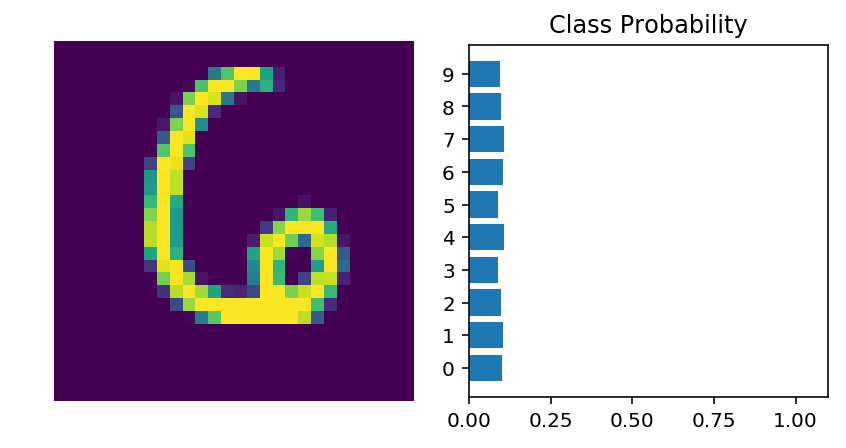

In [15]:
## Class type
class myNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 400, 64, 100 units each
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        # Output layer, 10 units - one for each digit
        self.fc4 = nn.Linear(100, 10)
        
    # x : tensor
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        
        return x

model = myNetwork()
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
  (7): Softmax()
)


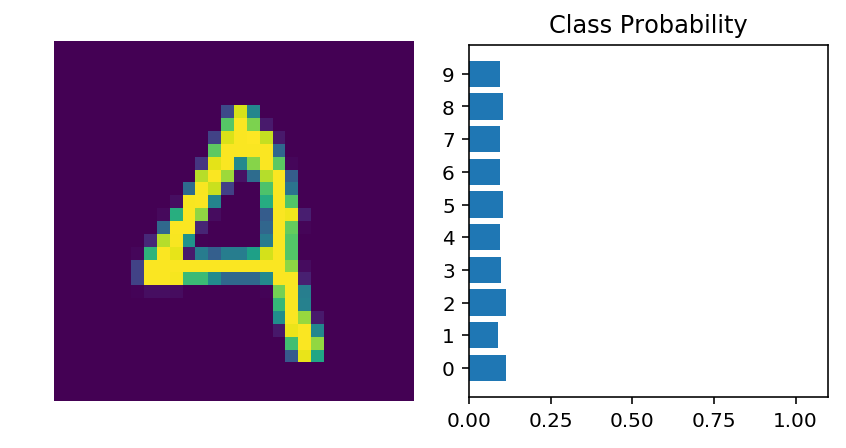

In [16]:
## Sequential Type
# Hyperparameters for our network
input_size = 784
hidden_sizes = [400, 200, 100]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

Sequential(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
  (softmax): Softmax()
)


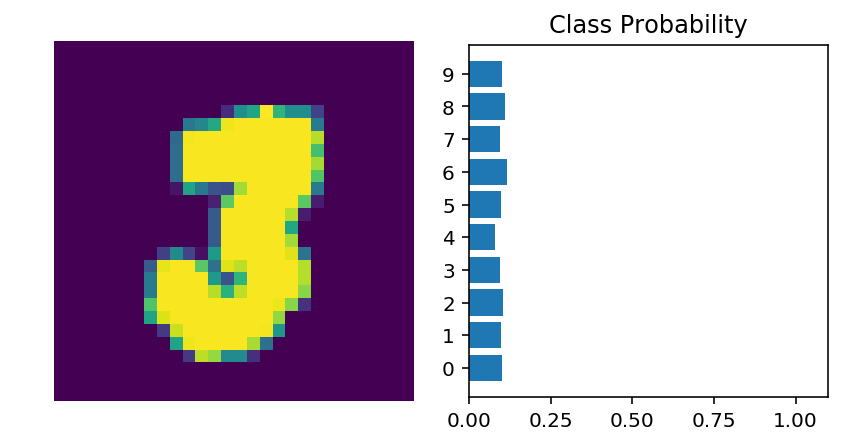

In [18]:
## Sequential type with OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                      ('output', nn.Linear(hidden_sizes[2], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)